In [1]:
# libraries
import pandas as pd
from pathlib import Path
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset

In [2]:
#device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
def robust_scale(x, eps=1e-6):
    median = np.median(x)
    mad = np.median(np.abs(x - median))
    return (x - median) / (mad + eps)

def build_label_vector(
    df_signal,
    df_peaks,
    plant_idx,
    channel,
    multiplex,
    sigma=10,
):
    molw = df_signal["molw"].values
    Y = np.zeros(len(molw), dtype=np.float32)

    dfp = df_peaks[
        (df_peaks["channel"] == channel) &
        (df_peaks["plant_id"] == plant_idx) &
        (df_peaks["multiplex"] == multiplex) &
        (df_peaks["peak_kind"] == "main")
    ]

    for _, row in dfp.iterrows():
        mu = row["mu_pb"]

        left = mu - sigma
        right = mu + sigma

        mask = (molw >= left) & (molw <= right)
        Y[mask] = 1.0

    return Y


class PeakDataset(Dataset):
    def __init__(self, csv_files):
        self.samples = []
        self.labels = []
        for csv_path in csv_files:
            df_signal = pd.read_csv(csv_path, sep=";")

            for ch in ["channel_1", "channel_2", "channel_3",
                       "channel_4"]:
                ch_idx = int(ch.split("_")[1])
                plant_idx = int(csv_path.stem.split("_pl")[-1])
                multiplex = int(csv_path.stem.split("M")[-1].split("_pl")[0])

                df_peaks = pd.read_csv("../Data/synthetic_ce_outputs_v5/peak_positions_detailed.csv",
                    sep=","
                )

                x = df_signal[ch].values.astype(np.float32)
                #print("x.shape",x.shape)
                # check length
                assert len(x) == 4961

                x = robust_scale(x)

                # shape (1, 4969)
                x = torch.from_numpy(x).unsqueeze(0)
                print(plant_idx, ch_idx, multiplex, x.shape)
                y = build_label_vector(
                    df_signal,
                    df_peaks,
                    plant_idx,
                    channel=ch_idx,
                    multiplex=multiplex
                )
                y = torch.from_numpy(y)

                self.samples.append(x)
                self.labels.append(y)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]


In [4]:
from torch.utils.data import DataLoader

csv_files = list(Path("../Data/synthetic_ce_outputs_v5/csv").glob("*.csv"))
#number of files in the folder
print(f"Number of CSV files found: {len(csv_files)}")
dataset = PeakDataset(csv_files)
x_data = dataset.samples
y_data = dataset.labels

print(len(x_data))
print(len(y_data))



Number of CSV files found: 40
5020 1 2 torch.Size([1, 4961])
5020 2 2 torch.Size([1, 4961])
5020 3 2 torch.Size([1, 4961])
5020 4 2 torch.Size([1, 4961])
5014 1 1 torch.Size([1, 4961])
5014 2 1 torch.Size([1, 4961])
5014 3 1 torch.Size([1, 4961])
5014 4 1 torch.Size([1, 4961])
5018 1 1 torch.Size([1, 4961])
5018 2 1 torch.Size([1, 4961])
5018 3 1 torch.Size([1, 4961])
5018 4 1 torch.Size([1, 4961])
5013 1 1 torch.Size([1, 4961])
5013 2 1 torch.Size([1, 4961])
5013 3 1 torch.Size([1, 4961])
5013 4 1 torch.Size([1, 4961])
5003 1 2 torch.Size([1, 4961])
5003 2 2 torch.Size([1, 4961])
5003 3 2 torch.Size([1, 4961])
5003 4 2 torch.Size([1, 4961])
5009 1 2 torch.Size([1, 4961])
5009 2 2 torch.Size([1, 4961])
5009 3 2 torch.Size([1, 4961])
5009 4 2 torch.Size([1, 4961])
5018 1 2 torch.Size([1, 4961])
5018 2 2 torch.Size([1, 4961])
5018 3 2 torch.Size([1, 4961])
5018 4 2 torch.Size([1, 4961])
5005 1 1 torch.Size([1, 4961])
5005 2 1 torch.Size([1, 4961])
5005 3 1 torch.Size([1, 4961])
5005 4 1 

In [5]:
print(len(x_data))
print(len(y_data))

print(x_data[0].shape)
print(y_data[0].shape)

160
160
torch.Size([1, 4961])
torch.Size([4961])


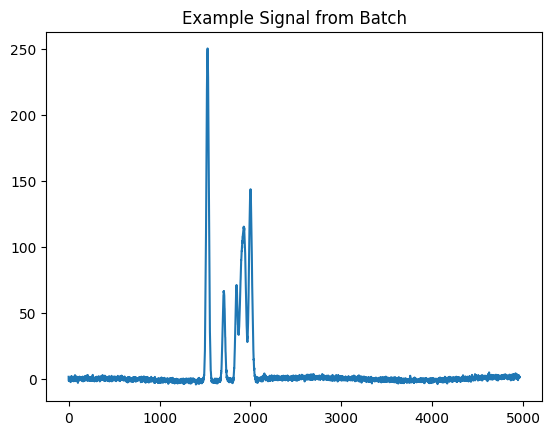

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.plot(x_data[0][0].numpy())
plt.title("Example Signal from Batch")
plt.show()

[0. 0. 0. ... 0. 0. 0.]


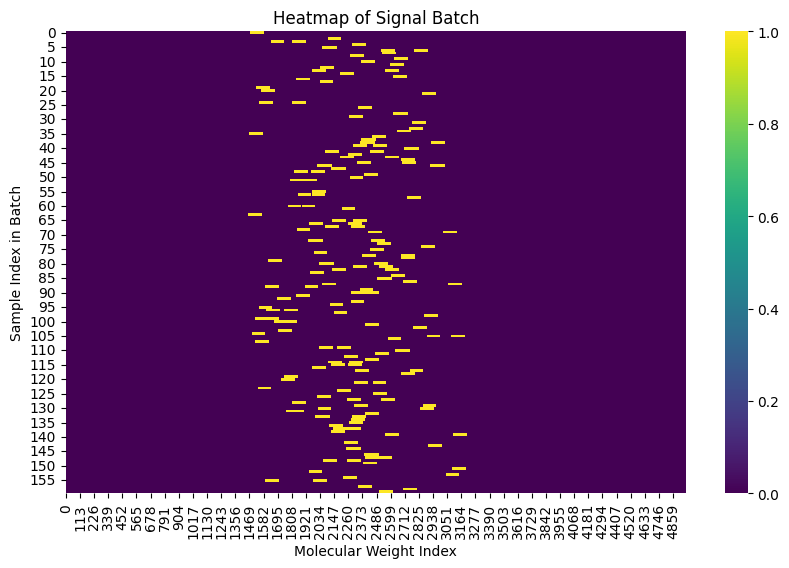

In [7]:
print(y_data[0].numpy())
plt.figure(figsize=(10, 6))
y_data = torch.stack(y_data)
sns.heatmap(y_data.squeeze().numpy(), cmap="viridis", cbar=True)
plt.title("Heatmap of Signal Batch")
plt.xlabel("Molecular Weight Index")
plt.ylabel("Sample Index in Batch")
plt.show()

In [ ]:
#!pip install matplotlib

  Using cached matplotlib-3.10.8-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (52 kB)
  Using cached contourpy-1.3.3-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.61.1-cp312-cp312-manylinux1_x86_64.manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_5_x86_64.whl.metadata (114 kB)
  Using cached kiwisolver-1.4.9-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (6.3 kB)
  Using cached pyparsing-3.3.1-py3-none-any.whl.metadata (5.6 kB)
Using cached matplotlib-3.10.8-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (8.7 MB)
Using cached contourpy-1.3.3-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (362 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.61.1-cp312-cp312-manylinux1_x86_64.manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_5_x86_64.whl (5.0 MB)
Using ca

In [8]:
# train test split
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader


X_train, X_test, y_train, y_test = train_test_split(
    x_data,
    y_data,
    test_size=0.2,
    random_state=42
)
X_train = torch.stack(X_train)        # shape: (N, C, H, W)
#y_train = torch.stack(y_train).float()
train_dataset = TensorDataset(X_train, y_train)

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    drop_last=True,
    num_workers=4,
    pin_memory=True
)

X_test = torch.stack(X_test)
#y_test = torch.stack(y_test).float()
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    drop_last=False,
    num_workers=4,
    pin_memory=True
)

In [10]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))
print(type(X_train))
print(type(X_train[0]))

128
128
32
32
<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [11]:
print(type(y_train))
print(type(y_test))

<class 'torch.Tensor'>
<class 'torch.Tensor'>


/home/frederic/Documents/Fil_rouge/cirse/lib/python3.12/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


torch.Size([32, 1, 4961])
tensor([[-0.7057, -1.0909, -0.2640,  ...,  1.5619,  0.7932,  0.0000]])
4961


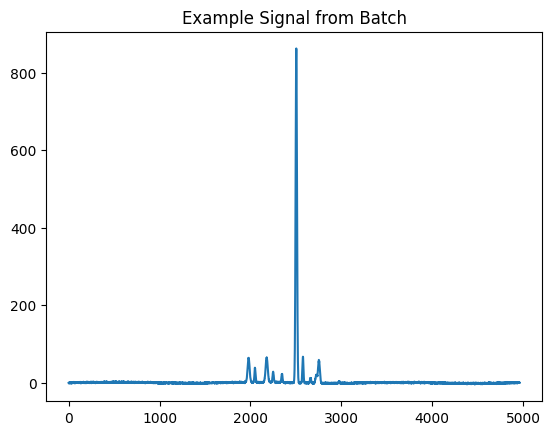

In [12]:

#visualisation of a batch
for x_batch, y_batch in train_loader:
    print(x_batch.shape)
    print(x_batch[2])
    print(len(x_batch[2][0]))
    break

# Example output:
# torch.Size([16, 1, 4961])

#signal plot
import matplotlib.pyplot as plt
plt.plot(x_batch[2][0].numpy())
plt.title("Example Signal from Batch")
plt.show()

In [ ]:
#!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


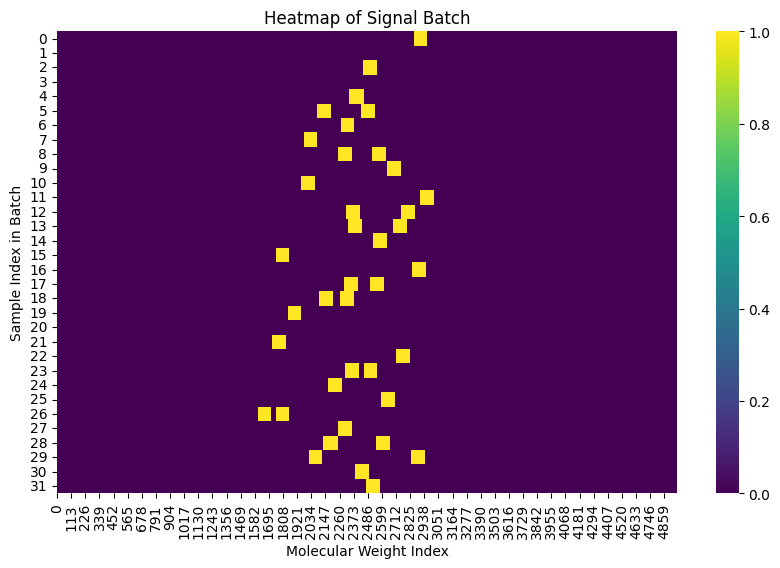

In [13]:

#visualisation of a batch as a heatmap
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.heatmap(y_batch.squeeze().numpy(), cmap="viridis", cbar=True)
plt.title("Heatmap of Signal Batch")
plt.xlabel("Molecular Weight Index")
plt.ylabel("Sample Index in Batch")
plt.show()

In [9]:
# Creation of a simple CNN 1D model
class SimpleCNN(nn.Module):
    def __init__(self, in_feature, hidden_unit, out_feature):
        super().__init__()

        self.block1 = nn.Sequential(
            nn.Conv1d(in_feature, hidden_unit, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.Conv1d(hidden_unit, hidden_unit, kernel_size=7, padding=3),
            nn.ReLU()
        )

        self.block2 = nn.Sequential(
            nn.Conv1d(hidden_unit, hidden_unit, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.Conv1d(hidden_unit, hidden_unit, kernel_size=7, padding=3),
            nn.ReLU()
        )

        self.classifier = nn.Conv1d(hidden_unit, out_channels=out_feature, kernel_size=1)

    def forward(self, x):
        x = self.block1(x)
        print("block1", x.shape)
        x = self.block2(x)
        print("block2", x.shape)
        x = self.classifier(x)
        print("classif", x.shape)
        return x.squeeze(1)  # (batch, 4961)


In [ ]:
#!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 13.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [torchmetrics] [torchmetrics]


In [ ]:
import torch.optim as optim
import torchmetrics
from torchmetrics.classification import MultilabelPrecision, MultilabelRecall
import tqdm as tqdm
# Instanciate the model
net = SimpleCNN(in_feature =1, hidden_unit= 5, out_feature=4961)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
#precision_recall = precision_recall(preds, target, average='macro', num_classes=3)
# device
net.to(device)

epochs = 5

# Training loop
net.train()
for epoch in tqdm.tqdm(range(epochs)):
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device).long()
        logits = net(x_batch)

        optimizer.zero_grad()
        loss = loss_fn(logits, y_batch)
        loss.backward()
        optimizer.step()
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).int()
        
        # Metrics
        precision = MultilabelPrecision(
            preds,
            y_batch.int(),
            num_labels=y_batch.shape[1],
            average="macro"
        )
        recall = MultilabelRecall(
            preds,
            y_batch.int(),
            num_labels=y_batch.shape[1],
            average="macro"
        )
        print("precision", precision)

    


  0%|          | 0/5 [00:00<?, ?it/s]

/home/frederic/Documents/Fil_rouge/cirse/lib/python3.12/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


block1 torch.Size([32, 5, 4961])
block2 torch.Size([32, 5, 4961])


In [58]:
import torchmetrics
print(torchmetrics.__version__)


1.8.2
